In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import ensemble
import sklearn.model_selection as ms
from sklearn import metrics
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import os
import math as m
from sklearn import svm

os.environ["CUDA_VISIBLE_DEVICES"] = '1,2,3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

print(tf.__version__)

2.1.0


In [2]:
def fileparser(path):
    df = pd.read_csv(path)
    df.drop(columns=['nbjet'], inplace=True)
    n = len(df)
    weight = int(round(np.mean(df.pop('weight').to_numpy()) * 3 * 1e6 * n))
    df_test = df.sample(frac=0.2).reset_index(drop=True)
    df.drop(df_test.index, inplace=True)
    return df, df_test, weight

In [3]:
df_yb2, df_yb2_test, weight_yb2 = fileparser("ROOT/inc_parton/yb2.csv")
df_ybyt, df_ybyt_test, weight_ybyt = fileparser("ROOT/inc_parton/ybyt.csv")
df_yt2, df_yt2_test, weight_yt2 = fileparser("ROOT/inc_parton/yt2.csv")
df_zh, df_zh_test, weight_zh = fileparser("ROOT/inc_parton/zh.csv")

df_train = pd.concat([df_yb2, df_ybyt, df_yt2, df_zh], ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [4]:
def runBDT(df, rf=False):
    X = df.drop(columns=['class'])
    y = df['class'].values

    """ Split for training and testing
    """
    x_train, x_test, y_train, y_test = ms.train_test_split(X.values, y, test_size=0.2, random_state=None)
    eval_set = [(x_train, y_train), (x_test, y_test)]
    """ Fit the decision tree
    """
    if rf: classifier = ensemble.RandomForestClassifier(max_depth=5, n_estimators=10, criterion='gini')
    else: classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.02, objective='multi:softprob', num_class=4, 
                                         nthread=6, subsample=0.2, colsample_bytree=1, n_estimators=1000)
    
    classifier = classifier.fit(x_train, y_train, early_stopping_rounds=50, eval_set=eval_set, 
                                eval_metric=["merror", "mlogloss"], verbose=False)
    
    """ Predictions
    """
    y_pred = classifier.predict(x_test)
    print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(y_test, y_pred)))
    
    X_shap = pd.DataFrame(x_test, columns=df.drop(columns=['class']).columns)
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_shap)
    # shap.summary_plot(shap_values, X_shap, plot_type='violin')
    shap.summary_plot(shap_values, X_shap, plot_type='bar', class_names=["zh", "yt2", "ybyt", "yb2"], class_inds='original')
    return classifier, x_test, y_test

In [14]:
def runSVC(df):
    X = df.drop(columns=['class'])
    y = df['class'].values

    """ Split for training and testing
    """
    x_train, x_test, y_train, y_test = ms.train_test_split(X.values, y, test_size=0.2, random_state=None)
    eval_set = [(x_train, y_train), (x_test, y_test)]
    """ Fit the SVM
    """
    classifier = svm.SVC(probability=True, kernel='poly', degree=10)
    classifier.fit(x_train, y_train)
    """ Predictions
    """
    y_pred = classifier.predict(x_test)
    print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(y_test, y_pred)))
    
    # explain all the predictions in the test set
    # X_shap = pd.DataFrame(x_test, columns=df.drop(columns=['class']).columns)
    # explainer = shap.KernelExplainer(classifier.predict_proba, x_train)
    # shap_values = explainer.shap_values(X_shap)
    # # shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)
    # shap.summary_plot(shap_values, X_shap, plot_type='bar', class_names=["zh", "yt2", "ybyt", "yb2"], class_inds='original')
    return classifier, x_test, y_test

    

In [ ]:
# classifier, x_test, y_test = runSVC(df_train)

Accuracy Score: 73.58% 


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


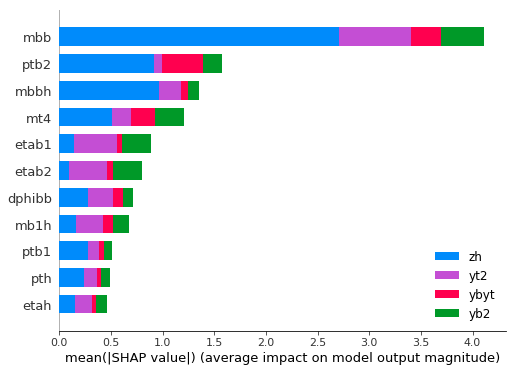

In [5]:
classifier, x_test, y_test = runBDT(df_train, rf=False)

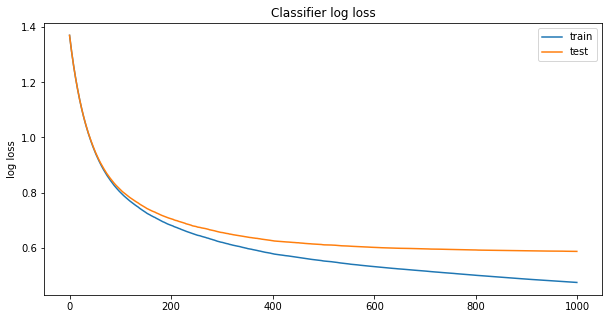

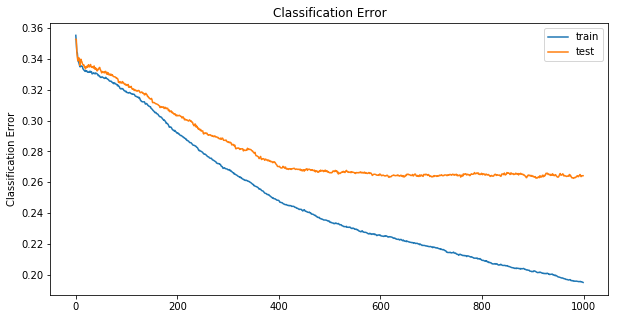

In [6]:
results = classifier.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='test')
ax.legend()
    
plt.ylabel('log loss')
plt.title('Classifier log loss')
plt.show()
    

# plot classification error
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, results['validation_0']['merror'], label='train')
ax.plot(x_axis, results['validation_1']['merror'], label='test')
ax.legend()

plt.ylabel('Classification Error')
plt.title('Classification Error')
plt.show()

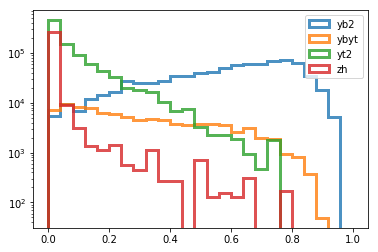

In [7]:
yb2_pred = pd.DataFrame(classifier.predict_proba(df_yb2_test.drop(columns=['class']).values)[:,3])
ybyt_pred = pd.DataFrame(classifier.predict_proba(df_ybyt_test.drop(columns=['class']).values)[:,3])
yt2_pred = pd.DataFrame(classifier.predict_proba(df_yt2_test.drop(columns=['class']).values)[:,3])
zh_pred = pd.DataFrame(classifier.predict_proba(df_zh_test.drop(columns=['class']).values)[:,3])

yb2_pred = yb2_pred.sample(n=weight_yb2, replace=True).reset_index(drop=True)
ybyt_pred = ybyt_pred.sample(n=-weight_ybyt, replace=True).reset_index(drop=True)
yt2_pred = yt2_pred.sample(n=weight_yt2, replace=True).reset_index(drop=True)
zh_pred = zh_pred.sample(n=weight_zh, replace=True).reset_index(drop=True)

sns.distplot(yb2_pred, kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label='yb2')
sns.distplot(ybyt_pred, kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label='ybyt')
sns.distplot(yt2_pred, kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label='yt2')
sns.distplot(zh_pred, kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label='zh')
plt.legend()
plt.yscale('log')

In [32]:
cut = 0.7
bdt_n_yb2 = yb2_pred.loc[yb2_pred.iloc[:,-1] > cut].shape[0]
bdt_n_ybyt = ybyt_pred.loc[ybyt_pred.iloc[:,-1] > cut].shape[0]
bdt_n_yt2 = yt2_pred.loc[yt2_pred.iloc[:,-1] > cut].shape[0]
bdt_n_zh = zh_pred.loc[yt2_pred.iloc[:,-1] > cut].shape[0]
sig = (bdt_n_ybyt)/m.sqrt(bdt_n_yb2 + bdt_n_ybyt + bdt_n_yt2 + bdt_n_zh)
print(bdt_n_yb2, "yb2-like events.", bdt_n_ybyt, "ybyt-like event.", bdt_n_yt2,
      "yt2-like event.", bdt_n_zh, "zh-like event.")
print("sig/sqrt(sig+bkg): ", sig)

5084 yb2-like events. 9632 ybyt-like event. 6325 yt2-like event. 1971 zh-like event.
sig/sqrt(sig+bkg):  63.494965453396674


In [36]:
class PrintDots(Callback):
    """ Print dots to monitor the progress of the fit
    """
    def on_epoch_end(self, epoch, logs):
        logs = logs or {}
        value = logs.get('val_loss')
        if epoch % 50 == 0:
            print(' epochs = ', epoch, ' val_loss = ', value)
        print('*', end='')

class TerminateOnBaseline(Callback):
    """ Callback that terminates training when monitored value reaches a specified baseline
    """
    def __init__(self, monitor='val_loss', patience=200):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = np.Inf
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        value = logs.get(self.monitor)
        if epoch == 0:
            self.baseline = value/100.
        if np.less(value, self.best):
            self.best = value
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
        if value is not None:
            if value <= self.baseline and self.wait >= self.patience:
                self.stopped_epoch = epoch
                print('\nepoch %d: Reached baseline, terminating training and lost patience' % epoch)
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch.')
                self.model.set_weights(self.best_weights)
            elif self.wait >= self.patience:
                self.baseline *= 2.5
                self.wait = self.patience/2
                print('\nbaseline increased since learning times is approaching death')
                
def plot_history(history):
    """ Plots to track the history of the metrics
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('accuracy [y]')
    plt.plot(hist['epoch'], hist['accuracy'], label='train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='val accuracy')
    plt.ylim([0.8, 1])
    plt.legend()
    plt.show()

    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()
    

In [37]:
def build_model(df):
    """ Build the model, define the optimizer and compile the model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(24, activation='relu', input_shape=[len(df.keys())-1]),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [38]:
model = build_model(df_yb2)
model.summary()    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 100       
Total params: 2,188
Trainable params: 2,188
Non-trainable params: 0
_________________________________________________________________


In [39]:
# learning_rate = 0.003
EPOCHS = 20000
patience = 50
df_train_set = df_train.copy(deep=True)
df_train_labels = df_train_set.pop('class')

""" Extract the history of the fit
"""
history = model.fit(
    df_train_set, df_train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size=320,
    callbacks=[TerminateOnBaseline(monitor='val_loss', patience=patience), PrintDots()])

""" Extract the history and make some plots
"""
print("\n", "Epochs = ", history.epoch[-1])

loss, accuracy = model.evaluate(df_yb2_test.iloc[:,:-1], df_yb2_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for yb2: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_ybyt_test.iloc[:,:-1], df_ybyt_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for ybyt: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_yt2_test.iloc[:,:-1], df_yt2_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for yt2: {:4.2f}%".format(accuracy*100))
loss, accuracy = model.evaluate(df_zh_test.iloc[:,:-1], df_zh_test.iloc[:,-1], verbose=0)
print("Testing set accuracy for zh: {:4.2f}%".format(accuracy*100))


 epochs =  0  val_loss =  1.0567757844924928
************************************************** epochs =  50  val_loss =  0.6772635847330093
************************************************** epochs =  100  val_loss =  0.6170622050762177
************************************************** epochs =  150  val_loss =  0.6055393278598785
************************************************** epochs =  200  val_loss =  0.6086895346641541
*************
baseline increased since learning times is approaching death
************************************* epochs =  250  val_loss =  0.6159366816282272
************************************************** epochs =  300  val_loss =  0.6055326014757156
***************************************
baseline increased since learning times is approaching death
*********** epochs =  350  val_loss =  0.6056846380233765
**************
baseline increased since learning times is approaching death
*************************
baseline increased since learning times is approach

In [ ]:
test_predictions_yb2 = model.predict(df_yb2_test.sample(n=weight_yb2, replace=True).reset_index(drop=True).iloc[:,:-1])[:,3]
test_predictions_ybyt = model.predict(df_ybyt_test.sample(n=-weight_ybyt, replace=True).reset_index(drop=True).iloc[:,:-1])[:,3]
test_predictions_yt2 = model.predict(df_yt2_test.sample(n=weight_yt2, replace=True).reset_index(drop=True).iloc[:,:-1])[:,3]
test_predictions_zh = model.predict(df_zh_test.sample(n=weight_zh, replace=True).reset_index(drop=True).iloc[:,:-1])[:,3]


plt.figure()
plt.hist(test_predictions_yb2, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3)
plt.hist(test_predictions_ybyt, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3)
plt.hist(test_predictions_yt2, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3)
plt.hist(test_predictions_zh, bins=np.arange(0, 1 + 0.04, 0.04), alpha=0.8, histtype='step', linewidth=3)
plt.yscale('log')

In [90]:
NN_n_sig = len(np.where(test_predictions_sig > 0.92)[0])
NN_n_bkg = len(np.where(test_predictions_bkg > 0.92)[0])
print(NN_n_sig, "signal events.", NN_n_bkg, "background event.")
print("sig/sqrt(sig+bkg): ",NN_n_sig/m.sqrt(NN_n_sig + NN_n_bkg))

365 signal events. 4439 background event.
sig/sqrt(sig+bkg):  5.266127443525946


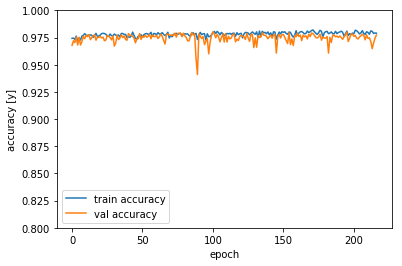

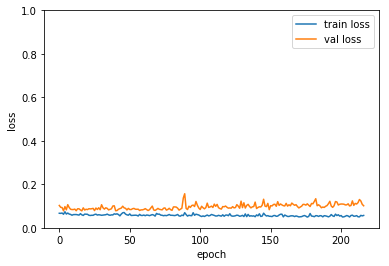

In [77]:
plot_history(history)